<!-- ### Table of content 

1- [Project Definition](#Definition)<br>
1.1- [Project Overview](#Overview)<br>
1.2- [Problem Statement](#Statement)<br> 
1.3- [Metrics](#Metrics)<br>
2- [Exploratory Data Analysis](#EDA)<br>
2.1- [Data Exploration and Visualization:](#Exploration)<br> 
2.1.A- [Portfolio Dataset](#Portfolio1)<br>
2.1.B- [Profile Dataset](#Profile1)<br> 
2.1.C- [Transcript Dataset](#Transcript1)<br> 
2.2- [Data Analysis](#Anaysis1)<br> 
3- [Data Preprocessing (Wrangling/Cleaning):](#Preprocessing)<br>
3.A- [Portfolio Dataset](#Portfolio2)<br>
3.B- [Profile Dataset](#Profile2)<br>
3.C-[Transcript Dataset](#Transcript2)<br>
4- [Data Modeling:](#Modeling)<br>
4.1- [Modeling](#Modeling)<br>
4.2- [Model Evaluation](#Evaluation)<br>
4.3- [Model Refinement](#Refinement)<br>
5- [Conclusion](#Conclusion)<br>
6- [Reflection](#Reflection)<br>
7- [Improvement](#Improvement)<br> -->

# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

### 1.1.2) Project's Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [1]:
import pandas as pd
import numpy as np
import math
import json
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib notebook

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor

In [2]:
# read in the json files
portfolio = pd.read_json('Data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('Data/profile.json', orient='records', lines=True)
transcript = pd.read_json('Data/transcript.json', orient='records', lines=True)

#  Portfolio Dataset

In [3]:
portfolio.head()

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


- Portfolio dataset contain -
<ol>
    <li> reward </li>
    <li> channels </li>
    <li> difficulty </li>
    <li> duration </li>
    <li> offer_type </li>
    <li> id </li>


</ol>

In [4]:
# data info

portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
reward        10 non-null int64
channels      10 non-null object
difficulty    10 non-null int64
duration      10 non-null int64
offer_type    10 non-null object
id            10 non-null object
dtypes: int64(3), object(3)
memory usage: 608.0+ bytes


In [5]:
# describe the dataset

profile.describe()

,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


In [6]:
# Number of row in the dataset 

print("Number of row in the dataset are : ", portfolio.shape[0])

Number of row in the dataset are :  10


In [7]:
# Number of column in the dataset 

print("Number of column in the dataset are : ", portfolio.shape[1])

Number of column in the dataset are :  6


In [8]:
# check weather there is a null value or not

portfolio.isnull().sum()

reward        0
channels      0
difficulty    0
duration      0
offer_type    0
id            0
dtype: int64

**There are no null value in the dataset.**

In [9]:
# checking the offer types the customer can receive
portfolio['offer_type'].unique()

array(['bogo', 'informational', 'discount'], dtype=object)

In [10]:
# check for how type pf offer there are

portfolio['offer_type'].value_counts()

discount         4
bogo             4
informational    2
Name: offer_type, dtype: int64

**There are 3 type offers**
- Boggo
- Discount
- informational

In [11]:
# datatype of dataframe

portfolio.dtypes

reward         int64
channels      object
difficulty     int64
duration       int64
offer_type    object
id            object
dtype: object

##### The above Exploration for the Portfolio Dataset shows the following: 
- The dataset has 6 columns and 10 rows.
- This dataset has no null values nor duplicates.
- There are three types of offers : 'bogo'(Buy One Get One free), 'informational' and 'discount'.
- There are 4 offers included in the dataset that are classified as : “bogo“ , 4 offers classified as : ”discount” and 2 offers classified as : “informational”.
- The 'difficulty' column unit is dollars , which does not reflect how difficult to be rewarded. Rescaling this feature is a useful step to do. **This needs to be done before Modeling.**

## Profile DataSet

In [12]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


- Profile dataset contain -
<ol>
    <li> Gender </li>
    <li> Age </li>
    <li> Id </li>
    <li> Became_member_on </li>
    <li> Income </li>


</ol>

In [13]:
# Number of row in the dataset 

print("Number of row in the dataset are : ", profile.shape[0])

Number of row in the dataset are :  17000


In [14]:
# Number of column in the dataset 

print("Number of column in the dataset are : ", profile.shape[1])

Number of column in the dataset are :  5


In [15]:
# data info

profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
gender              14825 non-null object
age                 17000 non-null int64
id                  17000 non-null object
became_member_on    17000 non-null int64
income              14825 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


In [16]:
# check weather there is a null value or not

profile.isnull().sum()

gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64

In [17]:
# describe the dataset

profile.describe()

,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


In [18]:
# datatype of dataframe

profile.dtypes

gender               object
age                   int64
id                   object
became_member_on      int64
income              float64
dtype: object

In [19]:
# # checking the unique values of difficulty column
# uniq_dif_sorted = np.sort(portfolio.difficulty.unique())
# uniq_dif_sorted

In [20]:
# check for age

profile.sort_values(by='age', ascending=False)

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
3510,None,118,a94d4b0cca4d47128920f66a5286431d,20180331,NaN
12484,None,118,b04385001db14fdf87829c6163ae9ddd,20160727,NaN
3483,None,118,d4309b7d75174eaa8115f4357b28cd98,20170917,NaN
12458,None,118,c28414b774094421b34abfe44c6d303c,20180313,NaN
...,...,...,...,...,...
16039,M,18,c17fdcb8833f4759bb2854aeb594ff6d,20151209,58000.0
12947,M,18,6bd1af2841a6412ebce35605cc4c394b,20150914,60000.0
14291,M,18,6bf6090ce6bf4dfa8c572d3f5fb1acc9,20160217,49000.0
10307,M,18,5a52e27405c84e58a0d7414562df9e10,20180417,40000.0


**How age can be 118......????????**


### Let's analyis for 118 year people.

In [21]:
profile[profile['age']==118].count()

gender                 0
age                 2175
id                  2175
became_member_on    2175
income                 0
dtype: int64

In [22]:
profile[['gender', "age", "income"]][profile['age']==118].head(10)

,gender,age,income
0,None,118,NaN
2,None,118,NaN
4,None,118,NaN
6,None,118,NaN
7,None,118,NaN
9,None,118,NaN
10,None,118,NaN
11,None,118,NaN
17,None,118,NaN
23,None,118,NaN


<IPython.core.display.Javascript object>


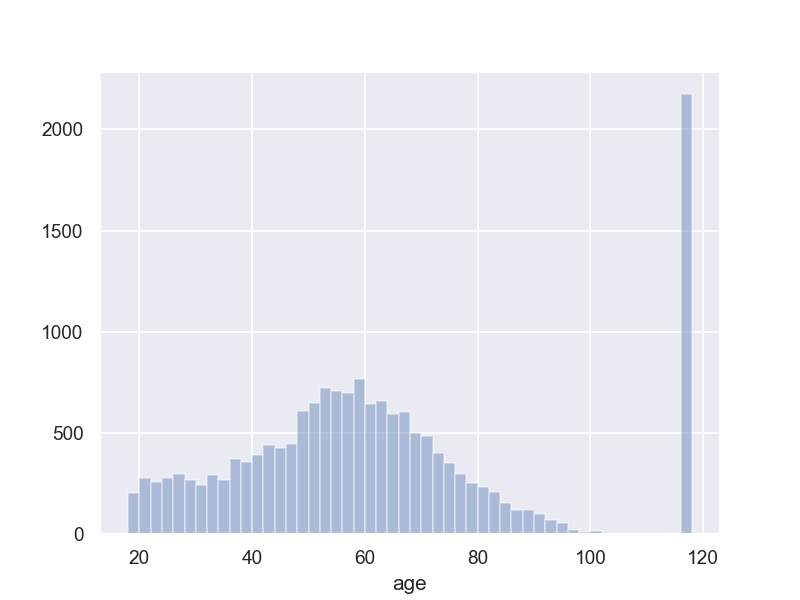

In [23]:
plt.figure()
sns.distplot(profile['age'], bins=50, kde=False);

**Hence, from the above analysis it's clear that people with age 118 are fake entries.**

In [24]:
# check the gender

profile['gender'].value_counts()

M    8484
F    6129
O     212
Name: gender, dtype: int64

\
\||- There are 8484 males
- There are 6129 feamles
- There are 212 others

##### The above Exploration and Visualization for the Profile Dataset shows the following: 
- The dataset has 5 columns and 17,000 rows.
- The dataset has no duplicated rows.
- The dataset has 2175 missing values on each of:  ‘gender’, ’income’ variables.
- The customers ages range from 18 to 101. Although that 2175  customers were registered at age 118 but I stilI considered this specific age an outlier b/c it appears clearly that there is something wrong related with these 2175 rows in the dataset.
- Exploring and visualizing three variables in this dataset: ‘gender’,’income’ and ’age’, allowed me to get the following conclusion: 
    -	The missing values in 'gender' and ‘income’ variables which are are related solely and specifically with the 2175 customers registered at age 118. In other words, customers at age 118 has no registered ‘gender’ and ‘income’. **This needs to be cleaned in the Data Preprocessing (Wrangling/Cleaning) Section.**
    -	Customers income ranges from 30,000 and 120,000 with most of the customers’ incomes fall between 50,000 and 75,0000.
    -	According to the available data, There are three ‘gender’ categories into which the customers falls in ( M, F and O).  Keeping in our mind the above observation that there are 2175 missing values, Male Customers (8484 men) are more than Female Customers(6129 women) with 57%  of customers are Males compared to 41% Females. However, there are 212 customers chose “O” as their gender.  

## Transcript Dataset¶


In [25]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


- Transcript dataset contain -
<ol>
    <li> Person </li>
    <li> Event </li>
    <li> Value </li>
    <li> Time </li>


</ol>

In [26]:
# Number of row in the dataset 

print("Number of row in the dataset are : ", transcript.shape[0])

Number of row in the dataset are :  306534


In [27]:
# Number of column in the dataset 

print("Number of column in the dataset are : ", transcript.shape[1])

Number of column in the dataset are :  4


In [28]:
# data info

transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
person    306534 non-null object
event     306534 non-null object
value     306534 non-null object
time      306534 non-null int64
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [29]:
# check weather there is a null value or not

transcript.isnull().sum()

person    0
event     0
value     0
time      0
dtype: int64

**There are no null values.**

In [30]:
# describe the dataset

transcript.describe()

,time
count,306534.000000
mean,366.382940
std,200.326314
min,0.000000
25%,186.000000
50%,408.000000
75%,528.000000
max,714.000000


In [31]:
# datatype of dataframe

transcript.dtypes

person    object
event     object
value     object
time       int64
dtype: object

In [32]:
# check the type of events

transcript['event'].value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

In [33]:
# #getting a random sample of 'value' column
# df_transaction['value'].sample(100)

##### The above Exploration for the Transcript Dataset shows the following: 
- The dataset has 4 columns and 306,534 rows.
- The dataset has no duplicated rows nor missing values.
- The ‘value’ column is a dictionary in which we can apply some kind of Feature Engineering to extract useful data that would surely contribute in the success of our future model. **This step will be done through the Data Preprocessing (Wrangling/Cleaning) Section.**
- There are four types of events in this dataset:  ‘transaction’, ’ offer received’, ‘offer viewed’ and ‘offer completed’.
- All the events that are classified as ‘transaction’ do not have an ‘offerid’ within its ‘value’ column.

<a id='Anaysis1'></a>
### 2.3) Data Analysis

This step will be posponed and performed after the Preprocessing and Merging steps. This is done since I believe that analyzing the master clean dataset will provide us with more accurate and reliable results.

**A Quick Data Analysis on the Master Dataset can be found** [Here](#Anaysis2)<br> 

<a id='Preprocessing'></a>
## 3) Data Preprocessing (Wrangling/Cleaning):

<a id='Portfolio2'></a>
### A- Portfolio Dataset

##### To preprocess this dataset we will do the following:
- Rename 'id' column to 'offer_id'.
- Change the unit of 'duration' column from days to hours.
- Rename 'duration' column to 'duration_h' representing that the unit of measurment is 'hours'
- Normalize 'difficulty'  and 'reward' features using the MinMaxScaler.
- Create dummy variables from the 'channels' column using one-hot encoding then Drop the 'channels' column.
- Replace the 'offer_id' by more easy ids.
- Replace the 'offer_type' by integers representing each offer type as follow:
    - 1 : bogo
    - 2 : discount
    - 3 : informational

In [39]:
portfolio_df = portfolio.copy()

In [40]:
portfolio_df.head()

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [41]:
# rename column id to offer_id

portfolio_df.rename(columns={'id':'offer_id'},inplace=True)

In [42]:
# info of dataset

portfolio_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
reward        10 non-null int64
channels      10 non-null object
difficulty    10 non-null int64
duration      10 non-null int64
offer_type    10 non-null object
offer_id      10 non-null object
dtypes: int64(3), object(3)
memory usage: 608.0+ bytes


In [43]:
# describe dataset

portfolio_df.describe()

,reward,difficulty,duration
count,10.000000,10.000000,10.000000
mean,4.200000,7.700000,6.500000
std,3.583915,5.831905,2.321398
min,0.000000,0.000000,3.000000
25%,2.000000,5.000000,5.000000
50%,4.000000,8.500000,7.000000
75%,5.000000,10.000000,7.000000
max,10.000000,20.000000,10.000000


In [44]:
# change duration column in hours

portfolio_df['duration'] = portfolio_df['duration']*24

In [45]:
# chnage the column name duration to duration_hours

portfolio_df.rename(columns={'duration':'duration_hours'}, inplace=True)

In [46]:
scaler = MinMaxScaler() 

numerical = ['difficulty','reward']

portfolio_df[numerical] = scaler.fit_transform(portfolio_df[numerical])



In [47]:
portfolio_df.head()

,reward,channels,difficulty,duration_hours,offer_type,offer_id
0,1.0,"[email, mobile, social]",0.50,168,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,1.0,"[web, email, mobile, social]",0.50,120,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0.0,"[web, email, mobile]",0.00,96,informational,3f207df678b143eea3cee63160fa8bed
3,0.5,"[web, email, mobile]",0.25,168,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,0.5,"[web, email]",1.00,240,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [48]:
# dataset info

portfolio_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
reward            10 non-null float64
channels          10 non-null object
difficulty        10 non-null float64
duration_hours    10 non-null int64
offer_type        10 non-null object
offer_id          10 non-null object
dtypes: float64(2), int64(1), object(3)
memory usage: 608.0+ bytes


**Split the channel into diffrent column**

Create dummy variables from 'channels'  column using one-hot encoding

In [49]:
#  channel

portfolio_df['channels']

0         [email, mobile, social]
1    [web, email, mobile, social]
2            [web, email, mobile]
3            [web, email, mobile]
4                    [web, email]
5    [web, email, mobile, social]
6    [web, email, mobile, social]
7         [email, mobile, social]
8    [web, email, mobile, social]
9            [web, email, mobile]
Name: channels, dtype: object

In [50]:
# split channel into diffrent column

portfolio_df['channel_web'] =  portfolio_df['channels'].apply(lambda x: 1 if 'web' in x else 0)

portfolio_df['channel_email'] = portfolio_df['channels'].apply(lambda x: 1 if 'email' in x else 0)


portfolio_df['channel_social'] = portfolio_df['channels'].apply(lambda x: 1 if 'social' in x else 0)

portfolio_df['channel_mobile'] = portfolio_df['channels'].apply(lambda x: 1 if 'mobile' in x else 0)


In [51]:
# check the column

portfolio_df[['channels','channel_email','channel_mobile','channel_web','channel_social']]

,channels,channel_email,channel_mobile,channel_web,channel_social
0,"[email, mobile, social]",1,1,0,1
1,"[web, email, mobile, social]",1,1,1,1
2,"[web, email, mobile]",1,1,1,0
3,"[web, email, mobile]",1,1,1,0
4,"[web, email]",1,0,1,0
5,"[web, email, mobile, social]",1,1,1,1
6,"[web, email, mobile, social]",1,1,1,1
7,"[email, mobile, social]",1,1,0,1
8,"[web, email, mobile, social]",1,1,1,1
9,"[web, email, mobile]",1,1,1,0


In [52]:
# drop the column channel

portfolio_df.drop('channels', axis=1, inplace=True)

In [53]:
portfolio_df.head()

,reward,difficulty,duration_hours,offer_type,offer_id,channel_web,channel_email,channel_social,channel_mobile
0,1.0,0.50,168,bogo,ae264e3637204a6fb9bb56bc8210ddfd,0,1,1,1
1,1.0,0.50,120,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1
2,0.0,0.00,96,informational,3f207df678b143eea3cee63160fa8bed,1,1,0,1
3,0.5,0.25,168,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,1
4,0.5,1.00,240,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,1,0,0


In [54]:
# dataset info

portfolio_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 9 columns):
reward            10 non-null float64
difficulty        10 non-null float64
duration_hours    10 non-null int64
offer_type        10 non-null object
offer_id          10 non-null object
channel_web       10 non-null int64
channel_email     10 non-null int64
channel_social    10 non-null int64
channel_mobile    10 non-null int64
dtypes: float64(2), int64(5), object(2)
memory usage: 848.0+ bytes


In [55]:

# change the column name offer_id to id

offer_ids = portfolio_df['offer_id'].astype('category').cat.categories.tolist()

chnage_map_offer_ids = {'offer_id' : {k: v for k,v in zip(offer_ids,list(range(1,len(offer_ids)+1)))}}

In [56]:
# check the new offer id


chnage_map_offer_ids

{'offer_id': {'0b1e1539f2cc45b7b9fa7c272da2e1d7': 1,
  '2298d6c36e964ae4a3e7e9706d1fb8c2': 2,
  '2906b810c7d4411798c6938adc9daaa5': 3,
  '3f207df678b143eea3cee63160fa8bed': 4,
  '4d5c57ea9a6940dd891ad53e9dbe8da0': 5,
  '5a8bc65990b245e5a138643cd4eb9837': 6,
  '9b98b8c7a33c4b65b9aebfe6a799e6d9': 7,
  'ae264e3637204a6fb9bb56bc8210ddfd': 8,
  'f19421c1d4aa40978ebb69ca19b0e20d': 9,
  'fafdcd668e3743c1bb461111dcafc2a4': 10}}

In [57]:
# replacing the categorical values in the 'offer_id' column by numberical values


portfolio_df.replace(chnage_map_offer_ids, inplace=True)

### Preprocessing 'offer_type' Feature

In [58]:
# chnage  the 'offer_type' by integers 

offer_types = portfolio_df['offer_type'].astype('category').cat.categories.tolist()

chnage_map_offer_types = {'offer_type' : {k: v for k,v in zip(offer_types,list(range(1,len(offer_types)+1)))}}

In [59]:
# check the new offer types

print(chnage_map_offer_types)

{'offer_type': {'bogo': 1, 'discount': 2, 'informational': 3}}


In [60]:
# replacing the categorical values in the 'offer_type' column by numberical values



portfolio_df.replace(chnage_map_offer_types, inplace=True)

In [61]:
# info

portfolio_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 9 columns):
reward            10 non-null float64
difficulty        10 non-null float64
duration_hours    10 non-null int64
offer_type        10 non-null int64
offer_id          10 non-null int64
channel_web       10 non-null int64
channel_email     10 non-null int64
channel_social    10 non-null int64
channel_mobile    10 non-null int64
dtypes: float64(2), int64(7)
memory usage: 848.0 bytes


# Profile Dataset

##### To preprocess this dataset we will do the following:
- Preprocessing 'id' Feature:
    - Rename 'id' column name to 'customer_id'.
    - Re-arrange the columns to have 'customer_id' column the first column in dataset.
    - Replace the customer_id string values  with easiest numerical values.
    
- Preprocessing 'age' Feature:
    - Replace age = 118 by NaN value.
    - Remove customers (drop rows) with no 'age', 'gender' and 'income'.
    - Change the datatype of 'age' and 'income' columns to 'int'.
    - Create a new column 'age_group' that includes the age_group to which each customer belongs
    - Replace the 'age_group' categorical label by a corresponding numerical label, as follows: 
        - 1 : teenager
        - 2 : young-adult
        - 3 : adult
        - 4 : elderly
        
- Preprocessing 'income' Feature:
    - Create a new column 'income_range' that includes the income-range to which the customer's income belongs.
    - Replace the 'income_range' categorical label by a corresponding numerical label, as follows: 
        - 1 : average (30,000 - 60,000)
        - 2 : above-average (60,0001 - 90,000)
        - 3 : high (more than 90,000)

- Preprocessing 'gender' Feature:
    - Replace the 'gender' categorical labels with coressponding numerical label, as follows:
        - 1 : F (Female)
        - 2 : M (Male)
        - 3 : O

- Preprocessing 'became_member_on' Feature:
    - Change the datatype of 'became_member_on' column from int to date and put it in the appropriate format in order to have a readable date format  that can be analyzed easily if requiered.
    - Add a new column 'start_year', that will present the year at which the customer become a member, to the existing dataset (for further analysis).
    - Add a new column 'membership_days' ,that will present the number of days since the customer became a member, to the existing dataset (for further analysis).
    - Create a new column 'member_type' representing the type of the member: new, regular or loyal depending on the number of his 'membership_days'.
    - Replace the 'member_type' categorical label by a corresponding numerical label, as follows: 
        - 1 : new (memebr since 1000 days or less)
        - 2 : regular (1001 - 1,600 days of membership)
        - 3 : loyal (more than 1,600 days of membership)

- Drop 'age','income', 'became_member_on' and 'membership_days' columns, since they are no longer needed.

In [62]:
# creating a copy from the dataset to be cleaned


profile_df = profile.copy()

In [63]:

profile_df.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [64]:
# Number of row in the dataset 

print("Number of row in the dataset are : ", profile_df.shape[0])

Number of row in the dataset are :  17000


In [65]:
# Number of column in the dataset 

print("Number of column in the dataset are : ", profile_df.shape[1])

Number of column in the dataset are :  5


In [66]:
# data info

profile_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
gender              14825 non-null object
age                 17000 non-null int64
id                  17000 non-null object
became_member_on    17000 non-null int64
income              14825 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


In [67]:
# describe the dataset

profile_df.describe()

,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


In [68]:
# chnage the column name id to customer_id 


profile_df.rename(columns={'id':'customer_id'},inplace=True)

In [69]:
# checking the existing columns' order


profile_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
gender              14825 non-null object
age                 17000 non-null int64
customer_id         17000 non-null object
became_member_on    17000 non-null int64
income              14825 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


In [70]:
# Re-arranging the columns


profile_df = profile_df.reindex(columns=['customer_id', 'age', 'became_member_on', 'gender', 'income'])

In [71]:
# check the column index


profile_df.columns

Index(['customer_id', 'age', 'became_member_on', 'gender', 'income'], dtype='object')

### Preprocessing 'id' Feature

In [72]:
# change the customer_id from string to numerical value


customer_ids = profile_df['customer_id'].astype('category').cat.categories.tolist()

change_map_customer_ids = {'customer_id' : {k: v for k,v in zip(customer_ids,list(range(1,len(customer_ids)+1)))}}

In [73]:
# replacing the  categorical labels in 'customer_id' column with numerical labels


profile_df.replace(change_map_customer_ids, inplace=True)

### Preprocessing  age Feature

In [74]:
# change age value 118 by NaN


profile_df['age'] = profile_df['age'].apply(lambda x: np.nan if x == 118 else x)

In [75]:


profile_df[profile_df['age'] == 118] 

,customer_id,age,became_member_on,gender,income


In [76]:
# drop the null value

profile_df.dropna(inplace=True)


In [77]:
# check weather profile_df dataset has null value or not


profile_df.isna().sum()

customer_id         0
age                 0
became_member_on    0
gender              0
income              0
dtype: int64

In [78]:
# changing the datatype of 'age' and 'income' columns to int


profile_df[['age', 'income']] = profile_df[['age', 'income']].astype(int)

### Age groups

In [79]:
# create a new column that represent the different age group


profile_df['age_group'] = pd.cut(profile_df['age'], bins=[17, 22, 35, 60, 103],labels=['teenager', 'young-adult', 'adult', 'elderly'])

In [80]:
profile_df['age_group']

1          adult
3        elderly
5        elderly
8        elderly
12         adult
          ...   
16995      adult
16996    elderly
16997      adult
16998    elderly
16999    elderly
Name: age_group, Length: 14825, dtype: category
Categories (4, object): [teenager < young-adult < adult < elderly]

In [81]:
# replacing the 'age_group' categorical labels by numerical labels


age_groups = profile_df['age_group'].astype('category').cat.categories.tolist()


change_map_age_groups = {'age_group' : {k: v for k,v in zip(age_groups,list(range(1,len(age_groups)+1)))}}

In [82]:
change_map_age_groups

{'age_group': {'teenager': 1, 'young-adult': 2, 'adult': 3, 'elderly': 4}}

In [83]:
# change the categorical value to numerical value

profile_df.replace(change_map_age_groups, inplace=True)

In [84]:


profile_df['age_group']

1        3
3        4
5        4
8        4
12       3
        ..
16995    3
16996    4
16997    3
16998    4
16999    4
Name: age_group, Length: 14825, dtype: int64

**Preprocessing 'income' Feature**

In [85]:
# create a new column for the icome range


profile_df['income_range'] = pd.cut(profile_df['income'], bins=[29999, 60000, 90000, 120001],labels=['average', 'above-average', 'high'])

In [86]:
# replacing the 'income_range' categorical labels by numerical labels


income_ranges = profile_df['income_range'].astype('category').cat.categories.tolist()


change_map_income_ranges = {'income_range' : {k: v for k,v in zip(income_ranges,list(range(1,len(income_ranges)+1)))}}

In [87]:
# checking the categorical labels and its corresponding numerical labels for 'income_range' column


change_map_income_ranges

{'income_range': {'average': 1, 'above-average': 2, 'high': 3}}

In [88]:
# replacing categorical labels in 'income_range' column with numerical labels


profile_df.replace(change_map_income_ranges, inplace=True)

### Gender feature

In [89]:
# replacing the 'gender' categorical labels with coressponding numerical label


genders = profile_df['gender'].astype('category').cat.categories.tolist()

change_map_gender = {'gender' : {k: v for k,v in zip(genders,list(range(1,len(genders)+1)))}}


profile_df.replace(change_map_gender, inplace=True)

In [90]:
# checking the numerical label and its corresponding categorical label


change_map_gender

{'gender': {'F': 1, 'M': 2, 'O': 3}}

### 'membership_days' Feature 

In [91]:
# chnage the datatype from int to date format

profile_df['became_member_on'] = pd.to_datetime(profile_df['became_member_on'], format = '%Y%m%d')

In [92]:
# add new column start year


profile_df['membership_year'] = profile_df['became_member_on'].dt.year

In [93]:
# adding a new column 'membership_days' ,that will present the number of days since the customer become a member


profile_df['membership_days'] = datetime.datetime.today().date() - profile_df['became_member_on'].dt.date


In [94]:
profile_df['membership_days'] = profile_df['membership_days'].dt.days

In [95]:
# creating a new column 'member_type' representing the type of the member: new, regular or loyal depending on the number of his 'membership_days'



profile_df['member_type'] = pd.cut(profile_df['membership_days'], bins=[390, 1000, 1600, 2500],labels=['new', 'regular', 'loyal'])

In [96]:
# replacing the 'member_type' categorical labels by numerical labels


member_types = profile_df['member_type'].astype('category').cat.categories.tolist()


change_map_member_type = {'member_type' : {k: v for k,v in zip(member_types,list(range(1,len(member_types)+1)))}}

In [97]:

change_map_member_type

{'member_type': {'new': 1, 'regular': 2, 'loyal': 3}}

In [98]:
# replacing categorical labels in 'member_type' column with numerical labels


profile_df.replace(change_map_member_type, inplace=True)

In [99]:
# drop the column

profile_df.drop(columns = ['age','income','became_member_on', 'membership_days'], axis=1, inplace=True)

In [100]:


profile_df.head()

,customer_id,gender,age_group,income_range,membership_year,member_type
1,399,1,3,3,2017,2.0
3,7997,1,4,3,2017,2.0
5,15044,2,4,2,2018,1.0
8,3729,2,4,1,2018,1.0
12,3060,2,3,1,2017,1.0


In [101]:
# dataset info


profile_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14825 entries, 1 to 16999
Data columns (total 6 columns):
customer_id        14825 non-null int64
gender             14825 non-null int64
age_group          14825 non-null int64
income_range       14825 non-null int64
membership_year    14825 non-null int64
member_type        14705 non-null float64
dtypes: float64(1), int64(5)
memory usage: 810.7 KB


# Transcript Dataset

##### To preprocess this dataset we will do the following:
- Rename 'time' column to 'time_h' representing that the unit of measurment is 'hours'.
- Preprocess 'person' Feature:
    - Rename 'person' column to 'customer_id'.
    - Replace the categorical values in 'customer_id' column by the newly initiated numerical values corresponding with each customer id, which resulted from the previous [preprocessing for 'id' feature](#customerid)<br> 

- Preprocess 'value' Feature:
    - Extract each key that exists in the 'value' column to a seperate column than dropping the 'value' column.
    - Fill all the NaNs in the 'offer_id' column with 'N/A' values (i.e. Not Applicable).
    - Drop the 'value' column since it is no longer needed.
       
- Preprocess 'event' Feature:
    - Excluding all events of 'transaction' or 'offer received' from our clean_transcript dataset.
    - Replace the 'event' categorical labels with coressponding numerical label, as follows:
        - 1 : offer completed
        - 2 : offer viewed
        
- Preprocess 'offer_id' Feature:
    - Replace the categorical values in the 'offer_id' column by the corresponding numerical values used initiated during [Preprocessing Portfolio Dataset](#offerid)<br>

In [135]:
# create a copy from the dataset to be cleaned


transcript_df = transcript.copy()

In [136]:
transcript_df.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [137]:
# Number of row in the dataset 


print("Number of row in the dataset are : ", transcript_df.shape[0])

Number of row in the dataset are :  306534


In [138]:
# Number of column in the dataset 


print("Number of column in the dataset are : ", transcript_df.shape[1])

Number of column in the dataset are :  4


In [139]:
# describe the dataset


transcript_df.describe()

,time
count,306534.000000
mean,366.382940
std,200.326314
min,0.000000
25%,186.000000
50%,408.000000
75%,528.000000
max,714.000000


In [140]:
# data info

transcript_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
person    306534 non-null object
event     306534 non-null object
value     306534 non-null object
time      306534 non-null int64
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [141]:
# rename the column 


transcript_df.rename(columns={'person':'customer_id','time':'time_h' },inplace=True)

In [142]:
# change the categorical value to numerical value


transcript_df.replace(change_map_customer_ids, inplace=True)

In [143]:


transcript_df['customer_id']

0          7997
1         10736
2         15044
3          9525
4          6940
          ...  
306529    12028
306530     6914
306531    10723
306532     7882
306533    12848
Name: customer_id, Length: 306534, dtype: int64

### Preprocessing value Feature

In [144]:


key = []
for index, row in transcript_df.iterrows():
    for i in row['value']:
        if i in key:
            continue
        else:
            key.append(i)

In [145]:
key

['offer id', 'amount', 'offer_id', 'reward']

In [146]:
# create column and specify datatype

transcript_df['offer_id'] = '' 


In [147]:
transcript_df['amount'] = 0  

In [148]:
transcript_df['reward'] = 0  

In [149]:

# update value by itrating the column


for index, row in transcript_df.iterrows():
    
    for i in row['value']:
        if i == 'offer_id' or i == 'offer id': 
            transcript_df.at[index, 'offer_id'] = row['value'][i]
        if i == 'amount':
            transcript_df.at[index, 'amount'] = row['value'][i]
        if i == 'reward':
            transcript_df.at[index, 'reward'] = row['value'][i]

In [150]:
# filling all the NaNs in the 'offer_id' 


transcript_df['offer_id'] = transcript_df['offer_id'].apply(lambda x: 'N/A' if x == '' else x)

In [151]:
# drop the value

transcript_df.drop('value', axis=1, inplace=True)

### Preprocessing event Feature

In [152]:
# excluding all events of 'transaction' from our clean_transcript dataset


transcript_df = transcript_df[transcript_df['event'] != 'transaction']



In [153]:
# excluding all events of 'offer received' 


transcript_df = transcript_df[transcript_df['event'] != 'offer received']

In [154]:
# chnage the categorical value to numerical value


events = transcript_df['event'].astype('category').cat.categories.tolist()


chnage_map_events = {'event' : {k: v for k,v in zip(events,list(range(1,len(events)+1)))}}

In [155]:
# checking the numerical label and its corresponding categorical label


chnage_map_events

{'event': {'offer completed': 1, 'offer viewed': 2}}

In [156]:
# replace categorical labels in 'event' column with numerical labels


transcript_df.replace(chnage_map_events, inplace=True)

### Preprocessing offer_id Feature

In [157]:
# chnage the categeorical value to numerical value


transcript_df.replace(chnage_map_offer_ids, inplace=True)

In [158]:


transcript_df.head()

,customer_id,event,time_h,offer_id,amount,reward
12650,3729,2,0,9,0,0
12651,13995,2,0,6,0,0
12652,1052,2,0,5,0,0
12653,170,2,0,8,0,0
12655,12744,2,0,6,0,0


In [159]:
transcript_df.describe()

,customer_id,event,time_h,offer_id,amount,reward
count,91304.000000,91304.000000,91304.000000,91304.000000,91304.0,91304.000000
mean,8514.685972,1.632229,371.488347,5.900114,0.0,1.803601
std,4913.250193,0.482201,198.071423,2.974758,0.0,2.942222
min,1.000000,1.000000,0.000000,1.000000,0.0,0.000000
25%,4251.000000,1.000000,198.000000,3.000000,0.0,0.000000
50%,8508.000000,2.000000,414.000000,6.000000,0.0,0.000000
75%,12775.000000,2.000000,534.000000,9.000000,0.0,3.000000
max,17000.000000,2.000000,714.000000,10.000000,0.0,10.000000


# Combine the dataset

In [160]:
# merge all the dataset


combine_df =transcript_df.merge(portfolio_df,how='left',on='offer_id')

combine_df = combine_df.merge(profile_df,how ='left', on = 'customer_id')

In [161]:

combine_df.head()

,customer_id,event,time_h,offer_id,amount,reward_x,reward_y,difficulty,duration_hours,offer_type,channel_web,channel_email,channel_social,channel_mobile,gender,age_group,income_range,membership_year,member_type
0,3729,2,0,9,0,0,0.5,0.25,120,1,1,1,1,1,2.0,4.0,1.0,2018.0,1.0
1,13995,2,0,6,0,0,0.0,0.00,72,3,0,1,1,1,3.0,3.0,1.0,2017.0,2.0
2,1052,2,0,5,0,0,1.0,0.50,120,1,1,1,1,1,1.0,4.0,1.0,2016.0,2.0
3,170,2,0,8,0,0,1.0,0.50,168,1,0,1,1,1,1.0,1.0,1.0,2016.0,2.0
4,12744,2,0,6,0,0,0.0,0.00,72,3,0,1,1,1,2.0,3.0,1.0,2014.0,3.0


In [162]:
# info

combine_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 91304 entries, 0 to 91303
Data columns (total 19 columns):
customer_id        91304 non-null int64
event              91304 non-null int64
time_h             91304 non-null int64
offer_id           91304 non-null int64
amount             91304 non-null int64
reward_x           91304 non-null int64
reward_y           91304 non-null float64
difficulty         91304 non-null float64
duration_hours     91304 non-null int64
offer_type         91304 non-null int64
channel_web        91304 non-null int64
channel_email      91304 non-null int64
channel_social     91304 non-null int64
channel_mobile     91304 non-null int64
gender             82304 non-null float64
age_group          82304 non-null float64
income_range       82304 non-null float64
membership_year    82304 non-null float64
member_type        81654 non-null float64
dtypes: float64(7), int64(12)
memory usage: 13.9 MB


In [163]:
# Number of row in the dataset 

print("Number of row in the dataset are : ", combine_df.shape[0])

Number of row in the dataset are :  91304


In [164]:
# Number of column in the dataset 

print("Number of column in the dataset are : ", combine_df.shape[1])

Number of column in the dataset are :  19


In [165]:
# desccribe

combine_df.describe()

,customer_id,event,time_h,offer_id,amount,reward_x,reward_y,difficulty,duration_hours,offer_type,channel_web,channel_email,channel_social,channel_mobile,gender,age_group,income_range,membership_year,member_type
count,91304.000000,91304.000000,91304.000000,91304.000000,91304.0,91304.000000,91304.000000,91304.000000,91304.000000,91304.000000,91304.000000,91304.0,91304.000000,91304.000000,82304.000000,82304.000000,82304.000000,82304.000000,81654.000000
mean,8514.685972,1.632229,371.488347,5.900114,0.0,1.803601,0.460228,0.398480,160.803733,1.668284,0.812812,1.0,0.705522,0.933376,1.574881,3.207074,1.748141,2016.539476,1.921204
std,4913.250193,0.482201,198.071423,2.974758,0.0,2.942222,0.334099,0.229856,49.816572,0.677449,0.390064,0.0,0.455810,0.249370,0.524742,0.766016,0.714276,1.175600,0.717769
min,1.000000,1.000000,0.000000,1.000000,0.0,0.000000,0.000000,0.000000,72.000000,1.000000,0.000000,1.0,0.000000,0.000000,1.000000,1.000000,1.000000,2013.000000,1.000000
25%,4251.000000,1.000000,198.000000,3.000000,0.0,0.000000,0.200000,0.250000,120.000000,1.000000,1.000000,1.0,0.000000,1.000000,1.000000,3.000000,1.000000,2016.000000,1.000000
50%,8508.000000,2.000000,414.000000,6.000000,0.0,0.000000,0.500000,0.500000,168.000000,2.000000,1.000000,1.0,1.000000,1.000000,2.000000,3.000000,2.000000,2017.000000,2.000000
75%,12775.000000,2.000000,534.000000,9.000000,0.0,3.000000,0.500000,0.500000,168.000000,2.000000,1.000000,1.0,1.000000,1.000000,2.000000,4.000000,2.000000,2017.000000,2.000000
max,17000.000000,2.000000,714.000000,10.000000,0.0,10.000000,1.000000,1.000000,240.000000,3.000000,1.000000,1.0,1.000000,1.000000,3.000000,4.000000,3.000000,2018.000000,3.000000


In [166]:
# drop the null value


combine_df = combine_df.dropna(how='any',axis=0) 

In [167]:
# info

combine_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 81654 entries, 0 to 91303
Data columns (total 19 columns):
customer_id        81654 non-null int64
event              81654 non-null int64
time_h             81654 non-null int64
offer_id           81654 non-null int64
amount             81654 non-null int64
reward_x           81654 non-null int64
reward_y           81654 non-null float64
difficulty         81654 non-null float64
duration_hours     81654 non-null int64
offer_type         81654 non-null int64
channel_web        81654 non-null int64
channel_email      81654 non-null int64
channel_social     81654 non-null int64
channel_mobile     81654 non-null int64
gender             81654 non-null float64
age_group          81654 non-null float64
income_range       81654 non-null float64
membership_year    81654 non-null float64
member_type        81654 non-null float64
dtypes: float64(7), int64(12)
memory usage: 12.5 MB



#  Data Analysis

**The question that I'm intrested to answer are :**

**1-** Which Age group has heighest number of Customers?

**2-** How much offer are viewed and completed?

**3-** Which are the most popular offer.?

**4-** Most of the customer belongs to which income range?

**5-** Which type of promotions(offers) each gender likes?



**To easily understand the below analysis, Reconvert the values of the following features from numerical values to its original categorical values. The following maping for the features numerical values will be used:**

- Mapping of Numerical values for  ‘age_group’ feature:
    - 1 : teenager
    - 2 : young-adult
    - 3 : adult
    - 4 : elderly
        
        
- Mapping of Numerical values for  ‘income_range’ feature:
    - 1 : average (30,000 - 60,000)
    - 2 : above-average (60,0001 - 90,000)
    - 3 : high (more than 90,000)


- Mapping of Numerical values for  ‘gender’ feature:
    - 1 : F (Female)
    - 2 : M (Male)
    - 3 : O






## Which Age group has heighest number of Customers?

- Mapping of Numerical values for  'offer_type' feature:
    - 1 : bogo
    - 2 : discount
    - 3 : informational

In [171]:
combine_df['age_group'] = combine_df['age_group'].map({1: 'teenager', 2: 'young-adult', 3:'adult', 4:'elderly'})

In [172]:
combine_df.age_group.value_counts()

adult          38845
elderly        31302
young-adult     8656
teenager        2851
Name: age_group, dtype: int64

<IPython.core.display.Javascript object>


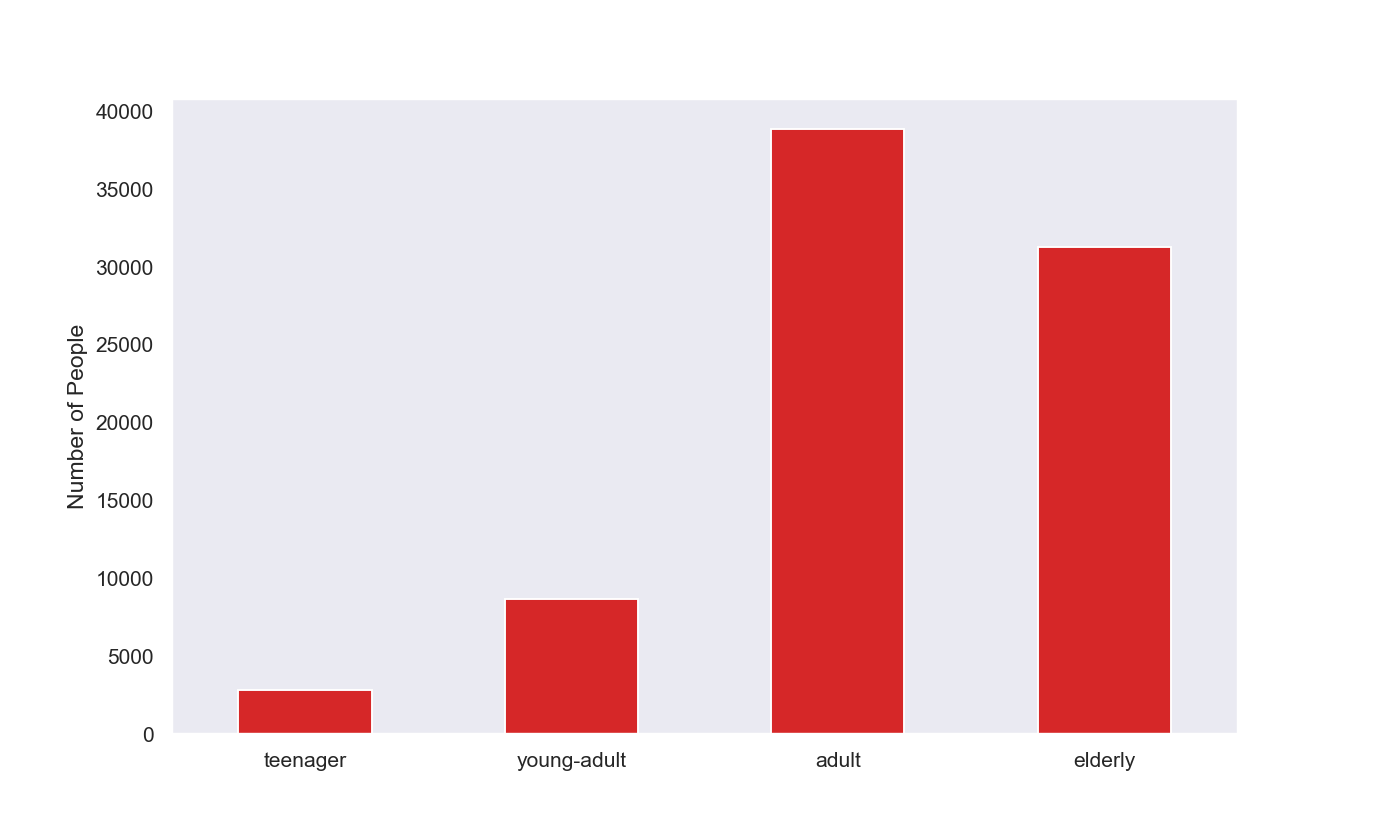

In [173]:
plt.figure(figsize=(10,5))

combine_df.age_group.value_counts().reindex(['teenager', 'young-adult', 'adult', 'elderly']).plot(kind='bar', rot=0, figsize=(10,6), color='tab:red');
plt.ylabel('Number of People');
plt.grid();

<IPython.core.display.Javascript object>


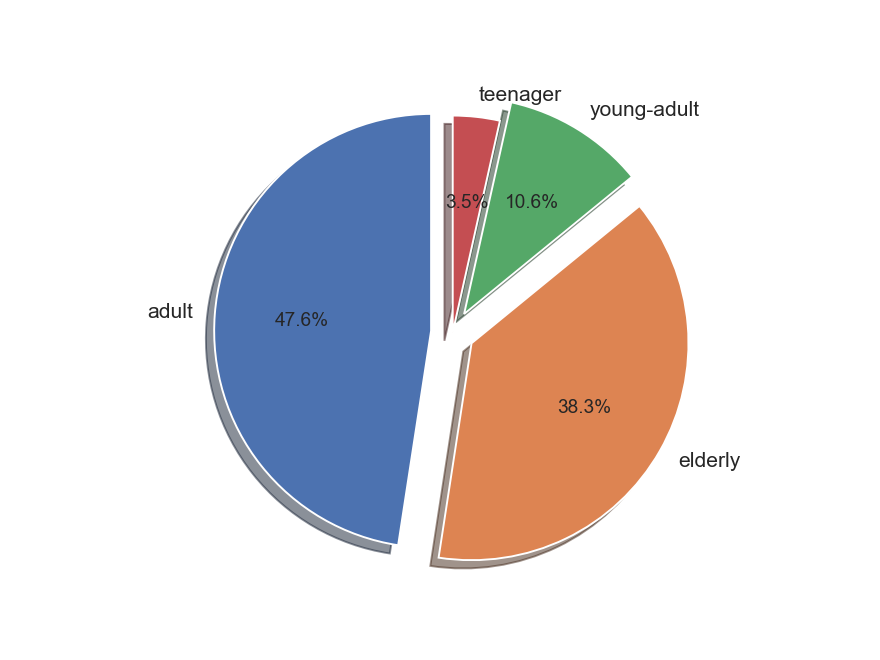

In [199]:
labels=['adult','elderly','young-adult','teenager']
values=[38845, 31302, 8656, 2851]

# adult          38845
# elderly        31302
# young-adult     8656
# teenager        2851

import matplotlib.pyplot as plt
explode=(0.10,0.10,0.10,0)

fig1, ax1 = plt.subplots()
ax1.pie(values, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal') 
plt.show()

## How much offer are viewed and completed?

- Mapping of Numerical values for  event feature -
    - 1 : offer completed
    - 2 : offer viewed


In [174]:
combine_df['event'] = combine_df['event'].map({1: 'Completed', 2: 'Viewed'})


In [175]:
combine_df.event.value_counts()

Viewed       49462
Completed    32192
Name: event, dtype: int64

<IPython.core.display.Javascript object>


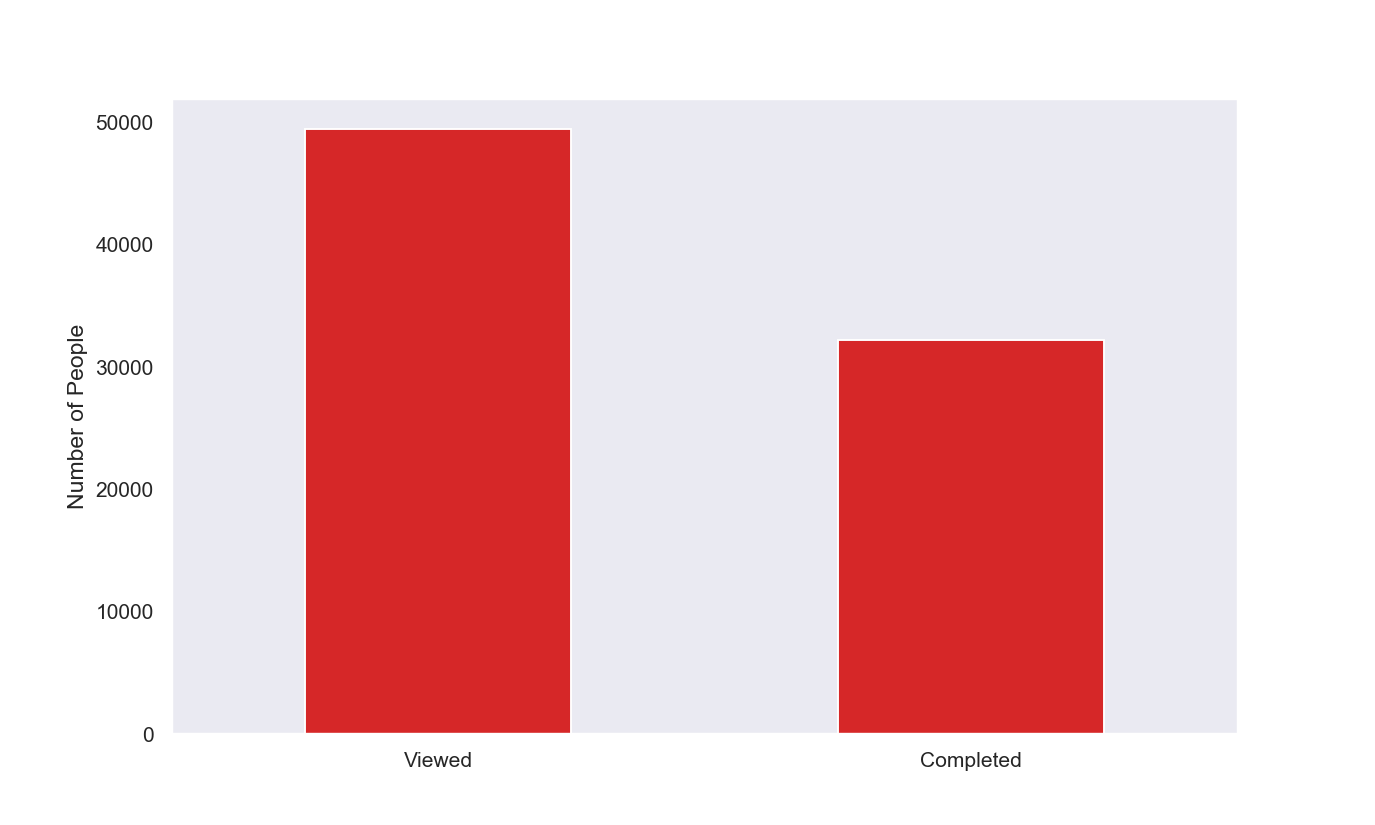

In [176]:
plt.figure(figsize=(10,5))

combine_df.event.value_counts().reindex(['Viewed', 'Completed']).plot(kind='bar', rot=0, figsize=(10,6), color='tab:red');
plt.ylabel('Number of People');
plt.grid();

## Which are the most popular offer.?


- Mapping of Numerical values for  offer_type feature - 
    - 1 : bogo
    - 2 : discount
    - 3 : informational


In [177]:
combine_df['offer_type'] = combine_df['offer_type'].map({1: 'BOGO', 2: 'Discount', 3: 'Informational'})


In [178]:
combine_df.offer_type.value_counts()

BOGO             37006
Discount         35357
Informational     9291
Name: offer_type, dtype: int64

<IPython.core.display.Javascript object>


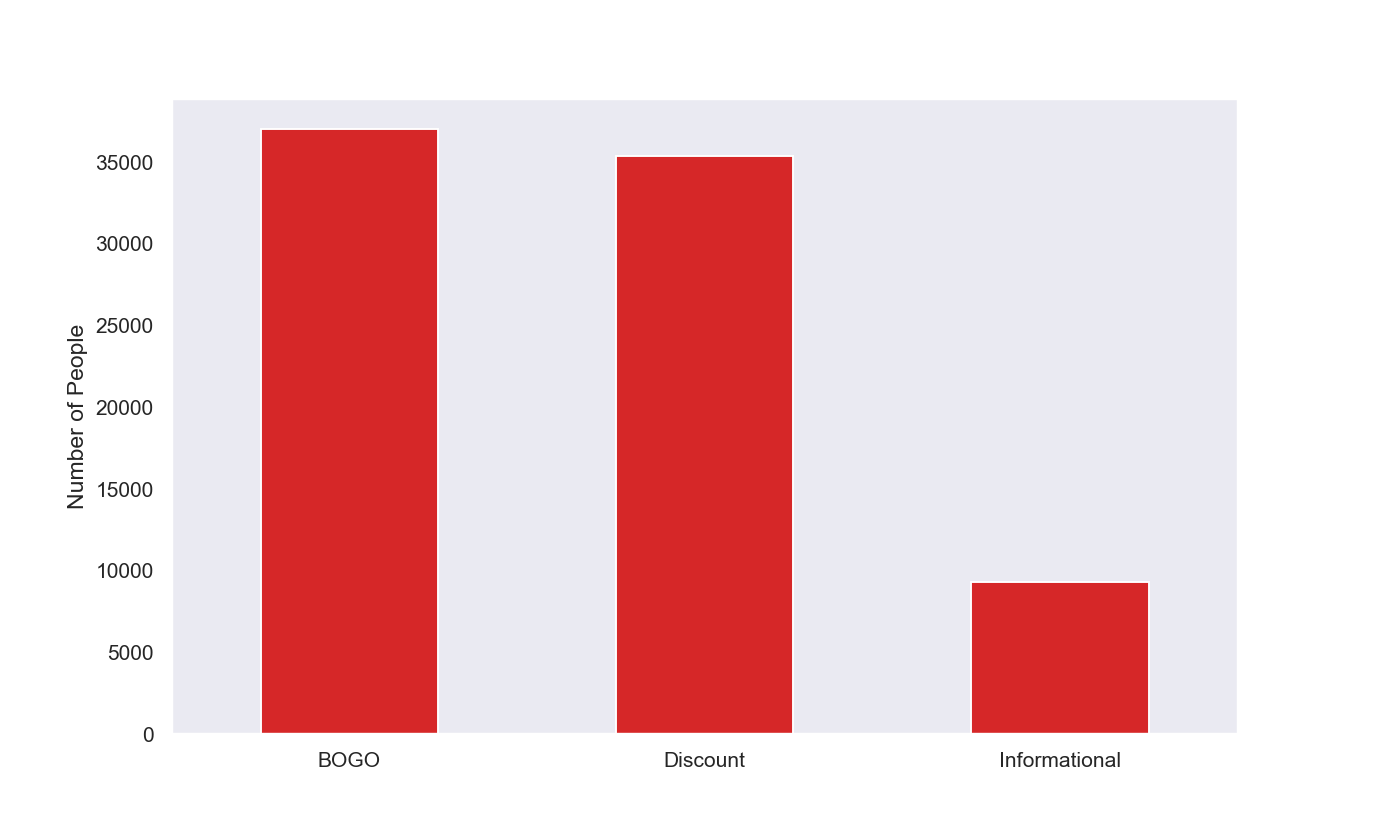

In [183]:
plt.figure(figsize=(10,5))

combine_df.offer_type.value_counts().reindex(['BOGO', 'Discount', 'Informational']).plot(kind='bar', rot=0, figsize=(10,6), color='tab:red');
plt.ylabel('Number of People');
plt.grid();

<IPython.core.display.Javascript object>


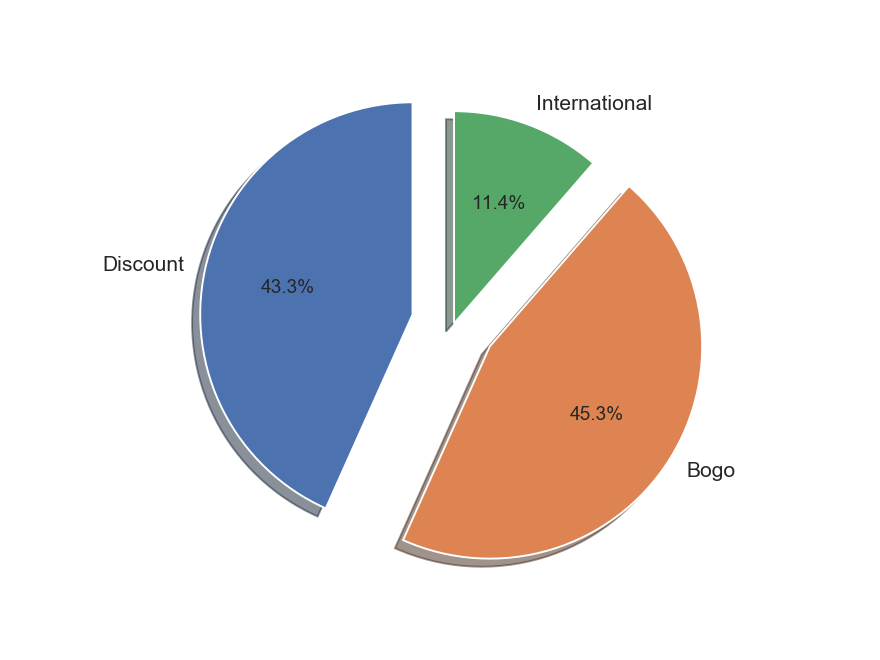

In [193]:
labels=['Discount','Bogo','International']
values=[35357,  37006, 9291]
import matplotlib.pyplot as plt
explode=(0.20,0.20,0)

fig1, ax1 = plt.subplots()
ax1.pie(values, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal') 
plt.show()

## Most of the customer belongs to which income range?

In [184]:
combine_df['income_range'] = combine_df['income_range'].map({1: 'Average', 2: 'Above-Average', 3:'High'})


In [185]:
combine_df.income_range.value_counts()

Above-Average    34844
Average          33627
High             13183
Name: income_range, dtype: int64

<IPython.core.display.Javascript object>


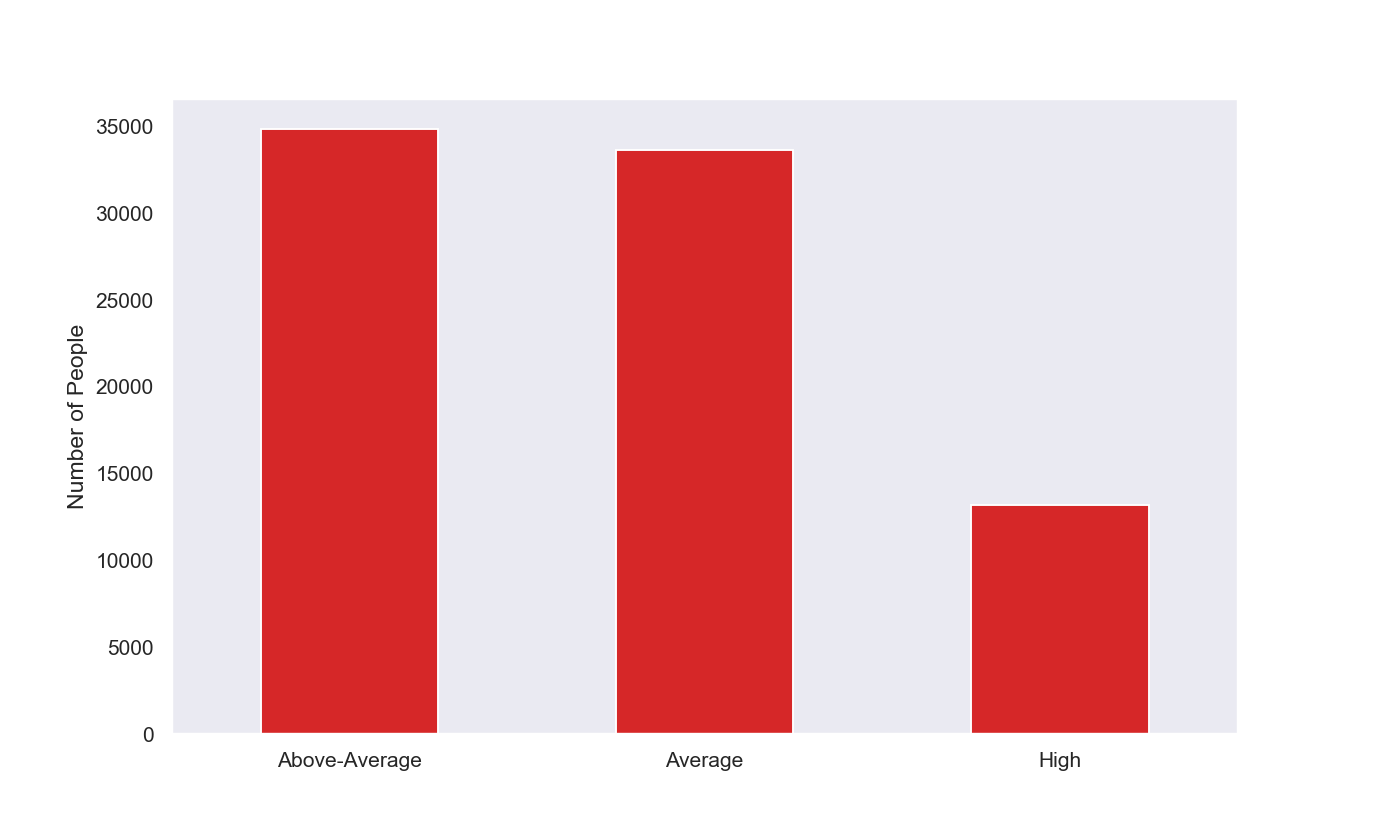

In [186]:
plt.figure(figsize=(10,5))

combine_df.income_range.value_counts().reindex(['Above-Average', 'Average', 'High']).plot(kind='bar', rot=0, figsize=(10,6), color='tab:red');
plt.ylabel('Number of People');
plt.grid();

<IPython.core.display.Javascript object>


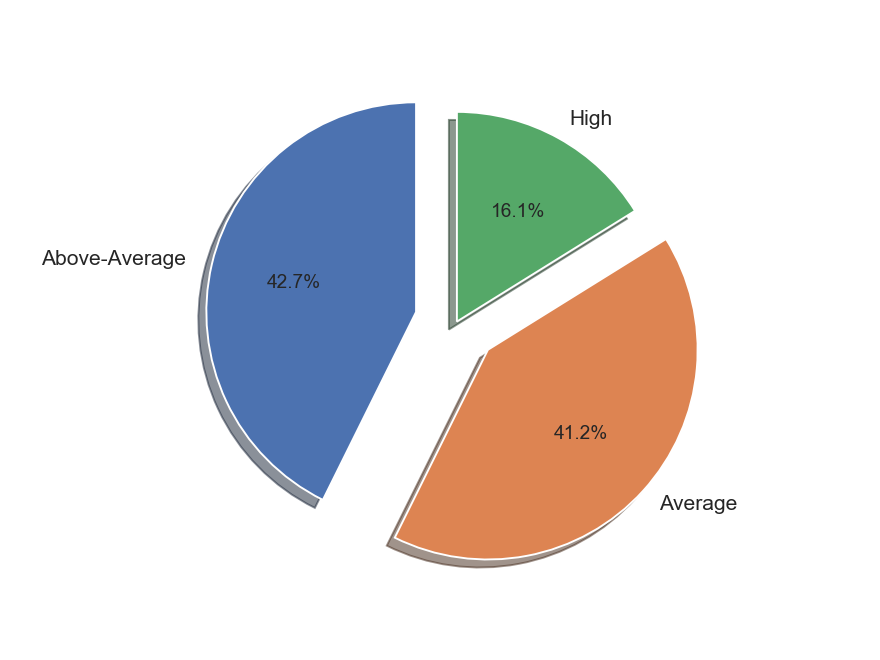

In [200]:
labels=['Above-Average ','Average','High']
values=[34844,  33627, 13183]
import matplotlib.pyplot as plt
explode=(0.20,0.20,0)

# Above-Average    34844
# Average          33627
# High             13183


fig1, ax1 = plt.subplots()
ax1.pie(values, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal') 
plt.show()

**1- What is the common offer each age group ( teenagers, young-adults, adults and elderly)?**

In [205]:
# plt.figure(figsize=(14, 6))
# g = sns.countplot(x="age_group", hue="offer_type", data=combine_df)
# plt.title('Most Popular Offers t
# o Each Age Group')
# plt.ylabel('Total')
# plt.xlabel('Age Group')
# xlabels = ['teenager','young-adult','adult','elderly']
# g.set_xticklabels(xlabels)
# plt.xticks(rotation = 0)
# plt.legend(title='Offer Type')
# plt.show();

The most common offer type among all age groups is the BOGO , followed by the Discount Offers. Whereas, the least common offer to be sent is the informational offers. I believe that BOGO offers are more attractive compared to other offers provided by Starbucks.

**2- Based on the demographic data of the customers who gets the highest income range , males or females?**

In [206]:
# plt.figure(figsize=(14, 6))
# g = sns.countplot(x="gender", hue="income_range", data= master_df[master_df["gender"] != 3])
# plt.title('Income Range vs Gender')
# plt.ylabel('Income Range')
# xlabels = ['Female', 'Male']
# g.set_xticklabels(xlabels)
# plt.xlabel('Gender')
# plt.xticks(rotation = 0)
# plt.show();

Customers with High income (Above 90,000) are mostly female customers. Whereas, Average Income(30,000 - 60,000) customers are mostly males.

**3- Who takes longer time to acheive each offer, Males or Females?**

Males and Females are pretty close when it comes to the time spent to complete an offer. Both males and females take about 17 days to da so.

In [207]:
# tran_avg_len_g_f = master_df.groupby(['gender', 'offer_id'])['time_h'].mean().reset_index()
# tran_avg_len_g_m = master_df.groupby(['gender', 'offer_id'])['time_h'].mean().reset_index()

# print(tran_avg_len_g_f[tran_avg_len_g_f['gender'] == 1.]['time_h'].values[0], tran_avg_len_g_f[tran_avg_len_g_f['gender'] == 1.]['time_h'].values[0] / 24)
# print(tran_avg_len_g_m[tran_avg_len_g_m['gender'] == 2.]['time_h'].values[0], tran_avg_len_g_m[tran_avg_len_g_m['gender'] == 2.]['time_h'].values[0] / 24)

**4- How many new members Starbucks got each year?**

In [208]:
# master_df['membership_year'] = master_df['membership_year'].astype(int)

In [209]:
# plt.figure(figsize=(16, 6))
# sns.countplot(master_df['membership_year'])
# plt.title('Number of Profiles In Each Year')
# plt.ylabel('Number of Profiles')
# plt.xlabel('Year')
# plt.xticks()
# plt.show();

In [210]:
# # getting the number of customers that became members on 2017
# members_2017 = (master_df['membership_year']==2017).sum()

# # getting the total number of members among all the available years
# total = master_df['membership_year'].count()

# # getting the percentages of customers that became members on 2017
# perc_2017 = round((members_2017/total)*100,2)

# print(members_2017)
# perc_2017

2017 was the best year for Starbucks in terms of the number of new members. Around %38 of all the customers on our dataset regiseterd as members on this specific year.

## Which type of offers each gender like ? 

<IPython.core.display.Javascript object>


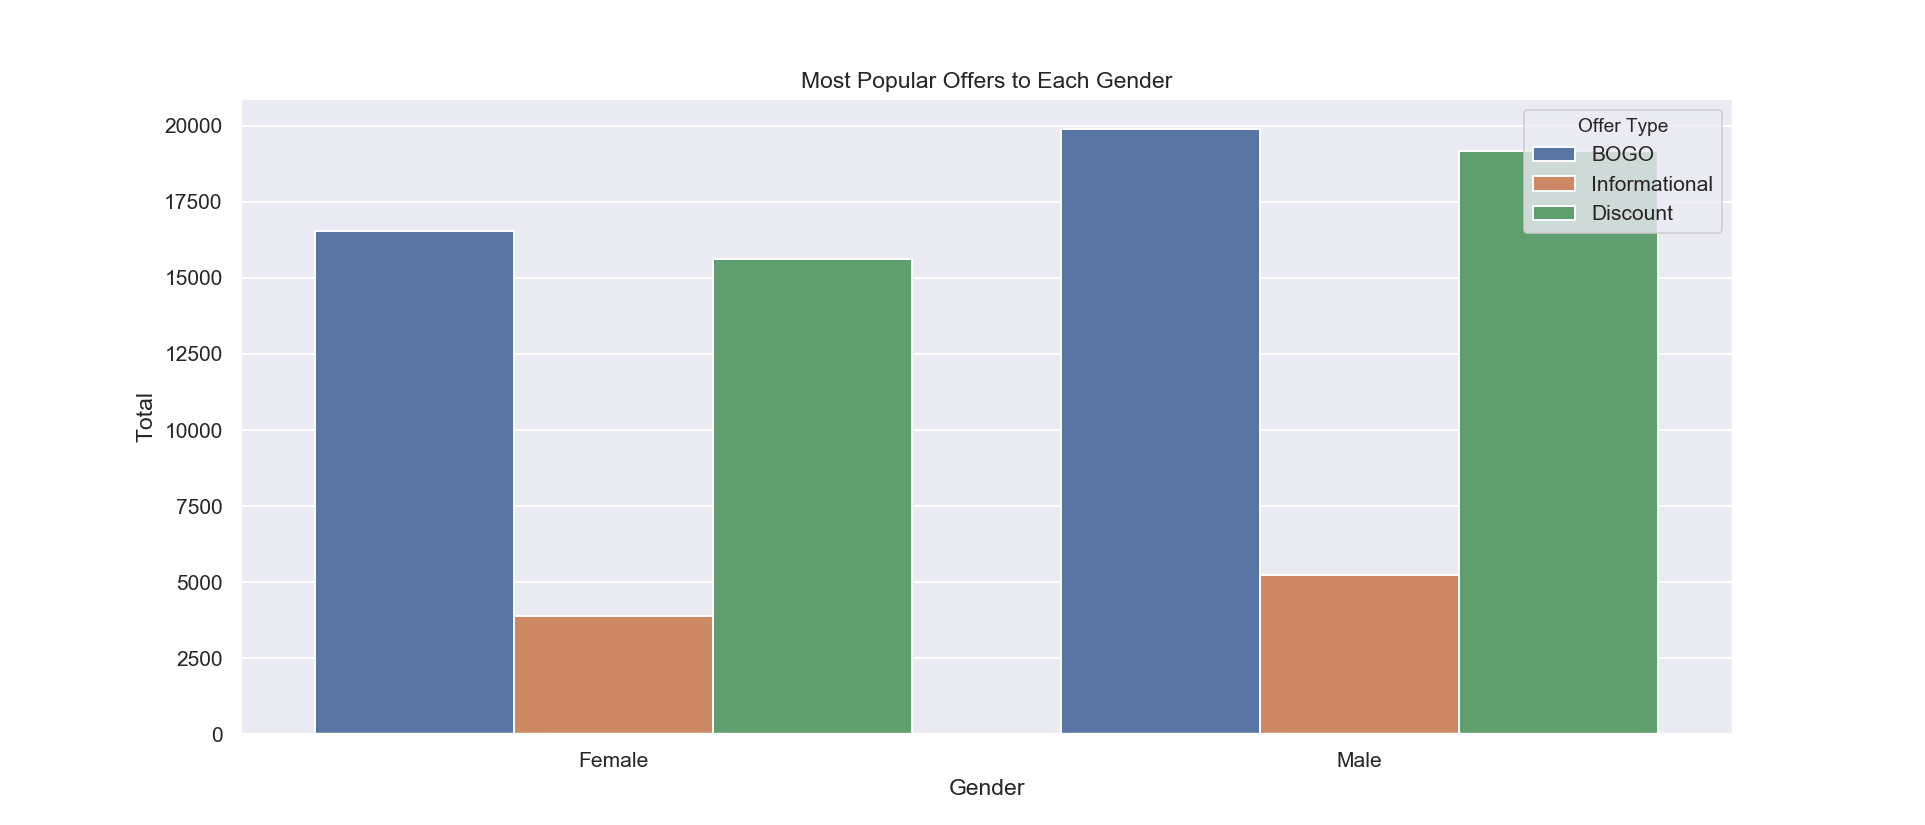

In [201]:
plt.figure(figsize=(14, 6))
g = sns.countplot(x='gender', hue="offer_type", data= combine_df[combine_df["gender"] != 3])
plt.title('Most Popular Offers to Each Gender')
plt.ylabel('Total')
plt.xlabel('Gender')
xlabels = ['Female', 'Male']
g.set_xticklabels(xlabels)
plt.legend(title='Offer Type')
plt.show();

The chart we got showed that both genders like BOGO and Discount offers and they have the same reaction toward Informational offers, they both seem to be not intersted to it.

**6- What is the average length between two transcript for the same customer?**

In [ ]:
# tran_avg_len = master_df.groupby(['customer_id', 'offer_id'])['time_h'].mean().reset_index()
# tran_avg_len['time_h'].mean(), tran_avg_len['time_h'].mean() / 24

The mean time it takes a customer to complete an offer is less than 16 days (372 hours).

**7- From all the offers the customers viewed , how many offers they completed?**

In [ ]:
# plt.figure(figsize=(14, 6))
# g = sns.countplot(x='gender', hue="event", data= master_df[master_df["gender"] != 3])
# plt.title('Most Popular Offers to Each Gender')
# plt.ylabel('Total')
# plt.xlabel('Gender')
# xlabels = ['Female', 'Male']
# g.set_xticklabels(xlabels)
# plt.legend(title='Offer Type')
# plt.show();

In [ ]:
# total_trans_g_o = master_df[master_df["gender"] != 3].groupby(['gender','offer_type']).count()
# total_trans_g_e = master_df[master_df["gender"] != 3].groupby(['gender','event']).count()
# total_trans_go_o_t = total_trans_g_o.loc[(1)]['event'].sum()
# total_trans_go_o_tt = total_trans_g_o.loc[(2)]['event'].sum()
# total_trans_go_o_t_offers_f = total_trans_g_o.loc[(1)].loc[['BOGO', 'Discount', 'Informational']]['event'].sum()
# total_trans_go_o_t_offers_m = total_trans_g_o.loc[(2)].loc[['BOGO', 'Discount', 'Informational']]['event'].sum()

In [ ]:
# print('For Females:')
# print(f"Number of offer completed: {total_trans_g_e.loc[(1, 'Completed')].values[0]}, {round((total_trans_g_e.loc[(1, 'Completed')].values[0]/total_trans_g_e.loc[(1, 'Viewed')].values[0])*100,2)}% of total offers viewed.")
# print(f"Number of offer viewed: {total_trans_g_e.loc[(1, 'Viewed')].values[0]}.")

# print('\nFor Males:')
# print(f"Number of offer completed: {total_trans_g_e.loc[(2, 'Completed')].values[0]}, {round((total_trans_g_e.loc[(2, 'Completed')].values[0]/total_trans_g_e.loc[(2, 'Viewed')].values[0])*100,2)}% of total offers viewed.")
# print(f"Number of offer viewed: {total_trans_g_e.loc[(2, 'Viewed')].values[0]}.")

Females completed around 75% of the offers they viewed, it is 16% more than males who just completed 58% of the offers they viewed. Feamles seems to be convinced by the promotion easier than males.

In [229]:
# Replacing the categorical values of the features by its corresponding numerical values, as before
events_new = combine_df['event'].astype('category').cat.categories.tolist()
change_map_events_new = {'event' : {k: v for k,v in zip(events_new,list(range(1,len(events_new)+1)))}}

income_ranges_new = combine_df['income_range'].astype('category').cat.categories.tolist()
chnage_map_income_new = {'income_range' : {k: v for k,v in zip(income_ranges_new,list(range(1,len(income_ranges_new)+1)))}}

offer_types_new = combine_df['offer_type'].astype('category').cat.categories.tolist()
chnage_map_offer_types_new = {'offer_type' : {k: v for k,v in zip(offer_types_new,list(range(1,len(offer_types_new)+1)))}}

combine_df.replace(change_map_events_new, inplace=True)
combine_df.replace(chnage_map_offer_types_new, inplace=True)
combine_df.replace(chnage_map_income_new, inplace=True)
combine_df.replace(change_map_age_groups, inplace=True)

In [231]:
# confirming changes
combine_df.head()

,customer_id,event,time_h,offer_id,amount,reward,reward_y,difficulty,duration_hours,offer_type,channel_web,channel_email,channel_social,channel_mobile,gender,age_group,income_range,membership_year,member_type
0,3729,2,0,9,0,0,0.5,0.25,120,1,1,1,1,1,2.0,4,2,2018.0,1.0
1,13995,2,0,6,0,0,0.0,0.00,72,3,0,1,1,1,3.0,3,2,2017.0,2.0
2,1052,2,0,5,0,0,1.0,0.50,120,1,1,1,1,1,1.0,4,2,2016.0,2.0
3,170,2,0,8,0,0,1.0,0.50,168,1,0,1,1,1,1.0,1,2,2016.0,2.0
4,12744,2,0,6,0,0,0.0,0.00,72,3,0,1,1,1,2.0,3,2,2014.0,3.0


<a id='Modeling'></a>
## 4) Data Modeling

### 4.1) Modeling

**Now, it is the time to build the model that can help us in predicting HOW will a given customer respond to an offer?**

In [232]:
combine_df.columns

Index(['customer_id', 'event', 'time_h', 'offer_id', 'amount', 'reward',
       'reward_y', 'difficulty', 'duration_hours', 'offer_type', 'channel_web',
       'channel_email', 'channel_social', 'channel_mobile', 'gender',
       'age_group', 'income_range', 'membership_year', 'member_type'],
      dtype='object')

**But first,** We need to split data into features and target labels, considering **ONLY** those features that we believe are important for our model to predict accurately. 

**Those features are as follows:**
    - time_h
    - offer_id
    - amount
    - reward_x ( Will be renamed to 'reward')
    - difficulty
    - duration_h
    - offer_type
    - gender
    - age_group
    - income_range
    - member_type

**Our target is:**
- 'event' that will be either:
    - 1 : offer completed
    - 2 : offer viewed

In [233]:
# Rename 'reward_x' column to 'reward'
combine_df.rename(columns ={'reward_x':'reward'}, inplace = True)

In [234]:
# Split the data into features and target label
X = combine_df[['time_h','offer_id','amount','reward','difficulty','duration_hours','offer_type','gender','age_group','income_range', 'member_type']]
Y = combine_df['event']

In [235]:
X.head()

,time_h,offer_id,amount,reward,difficulty,duration_hours,offer_type,gender,age_group,income_range,member_type
0,0,9,0,0,0.25,120,1,2.0,4,2,1.0
1,0,6,0,0,0.00,72,3,3.0,3,2,2.0
2,0,5,0,0,0.50,120,1,1.0,4,2,2.0
3,0,8,0,0,0.50,168,1,1.0,1,2,2.0
4,0,6,0,0,0.00,72,3,2.0,3,2,3.0


In [236]:
Y.head()

0    2
1    2
2    2
3    2
4    2
Name: event, dtype: int64

In [237]:
# normalizing some numerical values 
scaler = MinMaxScaler()
features = ['time_h', 'amount', 'reward', 'duration_hours']
X_scaled = X.copy()
X_scaled[features] = scaler.fit_transform(X_scaled[features])
X_scaled.head()

,time_h,offer_id,amount,reward,difficulty,duration_hours,offer_type,gender,age_group,income_range,member_type
0,0.0,9,0.0,0.0,0.25,0.285714,1,2.0,4,2,1.0
1,0.0,6,0.0,0.0,0.00,0.000000,3,3.0,3,2,2.0
2,0.0,5,0.0,0.0,0.50,0.285714,1,1.0,4,2,2.0
3,0.0,8,0.0,0.0,0.50,0.571429,1,1.0,1,2,2.0
4,0.0,6,0.0,0.0,0.00,0.000000,3,2.0,3,2,3.0


In [238]:
# creating training and testing sets 
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=42)

As mentioned in the [Metric Section above](#Metrics)<br> , in order to evaluate our models performance , we will use accuracy. This Metric was chosen for the following resons : 
- since we have  a simple classiifcation problem, i.e. either : offer viewed or offer completed. 
- It enables us to recognize HOW WELL our model is predicting by comparing the number of correct predictions witht the total number of predictions ( the concept of accuracy).

In [239]:
# defining a function to calculate the accuracy for the models we will try below 
def predict_score(model):
    pred = model.predict(X_test)
    
    # Calculate the absolute errors
    errors = abs(pred - y_test)
    
    # Calculate mean absolute percentage error
    mean_APE = 100 * (errors / y_test)
    accuracy = 100 - np.mean(mean_APE)
    
    return round(accuracy, 4)

**For Now, several models will be tried , then the best model along them would be chosen. Followed by an implementation for a GridSearch to find the best parameters ( in order to improve the performance of the chosen model)**

**1. Support Vector Machine**

In [249]:
from sklearn import svm
svm = svm.SVC(gamma = 'auto')

svm.fit(X_train, y_train)
print(f'Accuracy of SVM classifier on training set: {round(svm.score(X_train, y_train)*100,2)}%.')
print(f'Prediction Accuracy: {predict_score(svm)}%')

Accuracy of SVM classifier on training set: 100.0%.
Prediction Accuracy: 99.9829%


**2. Decision Tree**

In [250]:
dt = DecisionTreeClassifier()

dt.fit(X_train, y_train)
print(f'Accuracy of Decision Tree classifier on training set: {round(dt.score(X_train, y_train)*100,2)}%.')
print(f'Prediction Accuracy: {predict_score(dt)}%')

Accuracy of Decision Tree classifier on training set: 100.0%.
Prediction Accuracy: 100.0%


**3. Naive Bayes**

In [251]:
gnb = GaussianNB() 
gnb.fit(X_train, y_train) 
print(f'Accuracy of SVM classifier on training set: {round(gnb.score(X_train, y_train)*100,2)}%.')
print(f'Prediction Accuracy: {predict_score(gnb)}%')

Accuracy of SVM classifier on training set: 100.0%.
Prediction Accuracy: 100.0%


**4. K-Nearest Neighbors**

In [252]:
knn = KNeighborsClassifier()

knn.fit(X_train, y_train)
print(f'Accuracy of K-NN classifier on training set: {round(knn.score(X_train, y_train)*100,2)}%.')
print(f'Prediction Accuracy: {predict_score(knn)}%')

Accuracy of K-NN classifier on training set: 99.93%.
Prediction Accuracy: 99.902%


**5. Random Forest**

In [253]:
rf = RandomForestRegressor(n_estimators = 100, random_state = 42)

rf.fit(X_train, y_train)
print(f'Accuracy of SVM classifier on training set: {round(rf.score(X_train, y_train)*100,2)}%.')
print(f'Prediction Accuracy: {predict_score(rf)}%')

Accuracy of SVM classifier on training set: 100.0%.
Prediction Accuracy: 100.0%


**6. LogisticRegression**

In [254]:
logreg = LogisticRegression()

logreg.fit(X_train, y_train)
print(f'Accuracy of Logistic regression classifier on training set: {round(logreg.score(X_train, y_train)*100,2)}%.')
print(f'Prediction Accuracy: {predict_score(logreg)}%')

C:\Users\Lenovo\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Accuracy of Logistic regression classifier on training set: 100.0%.
Prediction Accuracy: 100.0%


<a id='Evaluation'></a>
### 4.2) Model Evaluation

In [321]:
# creating the variables that will be used to fill the results table
models = [svm, dt, gnb, knn, rf, logreg]
model_names = [type(n).__name__ for n in models]
training_accuracy = [x.score(X_train, y_train)*100 for x in models]
predection_accuracy = [predict_score(y) for y in models]

In [322]:
# structuring a table to view the results of the different model tried above
results = [training_accuracy, predection_accuracy]
results_df = pd.DataFrame(results, columns = model_names, index=['Training Accuracy', 'Predicting Accuracy']) 

In [323]:
# show the results dataframe 
results_df

,SVC,DecisionTreeClassifier,GaussianNB,KNeighborsClassifier,RandomForestRegressor,LogisticRegression
Training Accuracy,99.99352,100.0,100.0,99.917379,100.0,100.0
Predicting Accuracy,99.98780,100.0,100.0,99.880900,100.0,100.0


The above table, shows the accuracy score related with using different models of supervised learning. As presented on the table, we had 100% accuracy in both training and testing sets for 4 models ( out of 6). To avoid over fitting as much as possible, I will choose the model that gave me the lowest accuracy score on the testing set,which is the **KNeighborsClassifier**. On this model , I got 99.88% on testing set. I know that this is a very high score, but I the other scores are higher than that. I chose this model because I believe that is can be used on a  to solve a Binary outcome problem statement. On whther the customer will  view the offer ( just viewing) or he (complete the offer).

<a id='Refinement'></a>
### 4.3) Model Refinment

Althgough I believe on the saying  " There is always a room for Improvement", But I think that the **KNeighborsClassifier** model is giving me a really high score. Trying to improve such model will surely cause us to get into the fault of Overfitting. 
So, I will not suggest any improvement on this model since I believe that we don't need to try to get better results.

It worth nothing saying that I was planning to use the **GridSearchCV** to improve that model that I choose. That was the plan before getting hit by the Very High scores.

<a id='Conclusion'></a>
## 5) Conclusion

**Through this project , I tried to analyze the datasets provided by Starbucks and then build a model that can predict whether a customer would complete the offer or just view it?** 

First, I have explored each dataset, visualize it to get an overall understanding on the data. This also included analyzing different aspects of the datasets. Then, I moved to the Preprocessing Part. Preprocessing Data was the task that took most of the time and effort. The dataset is a bit tricky and the data included required me to use my wrangling/ engineering and preprocessing skills to get the final clean version of the three datasets. The next step was to create some latent features that can improve the performance of the model. These featured were actually derived from orginal existing column but with less range of values and simple values to include within the data set.  Examples on that are the following:

    - 'age_group' feature derived from 'age' feature. I was ,then, replace the feature's categorical labels by a corresponding numerical label, as follows: 
            - 1 : teenager
            - 2 : young-adult
            - 3 : adult
            - 4 : elderly
        
    -  'income_range' feature derived from 'income' feature. that includes the income-range to which the customer's income belongs. Then, I replaced the 'income_range' categorical labels by corresponding numerical labels, as follows: 
        - 1 : average (30,000 - 60,000)
        - 2 : above-average (60,0001 - 90,000)
        - 3 : high (more than 90,000)

    - 'member_type' feature derived from 'became_member_on' feature.  Of course, the features categorical labels has been replaced by corresponding numerical labels, as follows: 
        - 1 : new (memebr since 1000 days or less)
        - 2 : regular (1001 - 1,600 days of membership)
        - 3 : loyal (more than 1,600 days of membership)

**The quick analysis on the datasets allowed me to get the following insights:** 
- Customers income ranges from 30,000 and 120,000 with most of the customers’ incomes fall between 50,000 and 75,0000.
- According to the available data, There are three ‘gender’ categories into which the customers falls in ( M, F and O).  Keeping in our mind the above observation that there are 2175 missing values, Male Customers (8484 men) are more than Female Customers(6129 women) with 57%  of customers are Males compared to 41% Females. However, there are 212 customers chose “O” as their gender.  
- The most common offer type among all age groups is the BOGO , followed by the Discount Offers. Whereas, the least common offer to be sent is the informational offers. I believe that BOGO offers are more attractive compared to other offers provided by Starbucks.
- Customers with High income (Above 90,000) are mostly female customers. Whereas, Average Income(30,000 - 60,000) customers are mostly males.
- Males and Females are pretty close when it comes to the time spent to complete an offer. Both males and females take about 17 days to da so.
- 2017 was the best year for Starbucks in terms of the number of new members. Around %38 of all the customers on our dataset regiseterd as members on this specific year.
- Both genders like BOGO and Discount offers and they have the same reaction toward Informational offers, they both seem to be not interested to it.
- The mean time it takes a customer to complete an offer is less than 16 days (372 hours).
- Females completed around 75% of the offers they viewed, it is 16% more than males who just completed 58% of the offers they viewed. Feamles seems to be convinced by the promotion easier than males.

<a id='Reflection'></a>
## 6) Reflection
I really enjoyed working on this capstone project which allowed me to polish my skills in Data Preprocessing and Modeling. The most difficult part in my opinion was deciding on the problem statement. This is because a weak problem statement would surly cause the other work to be under appreciated and valued. 

The Preprocessing Step was the longest and most challanging part to complete. The Dataset itself is inspiring. Honestly,Everything was amazing.

<a id='Improvement'></a>
## 7) Improvement

I believe I got to a point where I had very good results when it comes to the prediction model. I understood the data provided by Starbucks very well.

As there is always space for improvment, I believe that the idea of improving the data coeelction or fixing issues related with the missing data or NaNs would be really helpful. In my opinion, I think that we can get great insights from this data set and great prediction models might be also built to solve problems statemetns associated with this data set . Examples for these model are the following : 

 -  Building a model that can predict which kind of offers to be sent to whcihc customer?
 - Building a model that can predict which customers would buy any way ( regardless if there is an offer or not)